In [1]:
import torch
import random
import numpy as np
import torchvision.datasets
import matplotlib.pyplot as plt
from itertools import product
import pickle
import time

In [2]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [3]:
MNIST_train = torchvision.datasets.MNIST('./', train=True)
MNIST_test = torchvision.datasets.MNIST('./', train=False)
X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels
X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()

/opt/conda/lib/python3.8/site-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/opt/conda/lib/python3.8/site-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/opt/conda/lib/python3.8/site-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/opt/conda/lib/python3.8/site-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [4]:
X_val = X_train[-5000:]
y_val = y_train[-5000:]

X_train = X_train[:-5000]
y_train = y_train[:-5000]

In [5]:
class LeNet5(torch.nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        
        self.conv1 = torch.nn.Conv2d(
            in_channels=1, out_channels=6, kernel_size=5, padding=2)
        self.act1  = torch.nn.Tanh()
        self.pool1 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        
        self.conv2 = torch.nn.Conv2d(
            in_channels=6, out_channels=16, kernel_size=5, padding=0)
        self.act2  = torch.nn.Tanh()
        self.pool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        
        self.fc1   = torch.nn.Linear(5 * 5 * 16, 120)
        self.act3  = torch.nn.Tanh()
        
        self.fc2   = torch.nn.Linear(120, 84)
        self.act4  = torch.nn.Tanh()
        
        self.fc3   = torch.nn.Linear(84, 10)
    
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)
        
        return x

In [6]:
resume = True

if resume: 
    with open('sgd_big_results.pkl', 'rb') as f:
        arr = pickle.load(f)
        test_accuracy_history_sgd = arr["acc"]
        test_loss_history_sgd = arr["loss"]
        loss_in_training_sgd = arr["loss_train"]
        time_learning_sgd = arr["time"]
else:
    test_accuracy_history_sgd, test_loss_history_sgd, loss_in_training_sgd, time_learning_sgd = {}, {}, {}, {}

In [ ]:
for learning_rate, weight_decay in product([0.1, 0.03, 0.01], [1e-3, 3e-4, 1e-4, 0]):
    
    key = (learning_rate, weight_decay)
    if key in test_accuracy_history_sgd:
        print("Already computed, ignoring")
        continue
    
    lenet5 = LeNet5()
    loss = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(lenet5.parameters(), lr=learning_rate, weight_decay=weight_decay)
    batch_size = 100
    
    test_loss_history_sgd[key] = list()
    test_accuracy_history_sgd[key] = list()
    loss_in_training_sgd[key] = list()
    time_learning_sgd[key] = list()

    for epoch in range(20):
        order = np.random.permutation(len(X_train))
        
        start_time = time.time()
        
        for start_index in range(0, len(X_train), batch_size):
            optimizer.zero_grad()
        
            batch_indexes = order[start_index:start_index+batch_size]
        
            X_batch = X_train[batch_indexes]
            y_batch = y_train[batch_indexes]
        
            preds = lenet5.forward(X_batch) 
        
            loss_value = loss(preds, y_batch)
            loss_value.backward()
            
            optimizer.step()
        
        time_learning_sgd[key].append(time.time() - start_time)
        loss_in_training_sgd[key].append(float(loss(lenet5.forward(X_train), y_train)))
        
        test_preds = lenet5.forward(X_val)
        test_loss_history_sgd[key].append(loss(test_preds, y_val).data)
    
        accuracy = (test_preds.argmax(dim=1) == y_val).float().mean().data
        test_accuracy_history_sgd[key].append(accuracy)
    
    print(test_accuracy_history_sgd[(learning_rate, weight_decay)])
    print(loss_in_training_sgd[(learning_rate, weight_decay)])
    with open('sgd_big_results.pkl', 'wb') as f:
        pickle.dump({"acc": test_accuracy_history_sgd, "loss": test_loss_history_sgd, "loss_train":loss_in_training_sgd, "time":time_learning_sgd}, f)

Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring
Already computed, ignoring


In [ ]:
colors = ['r', 'b', 'g', 'k', 'm', 'c', 'y', 'orange', 'teal', 'cyan', 'purple', 'deeppink']

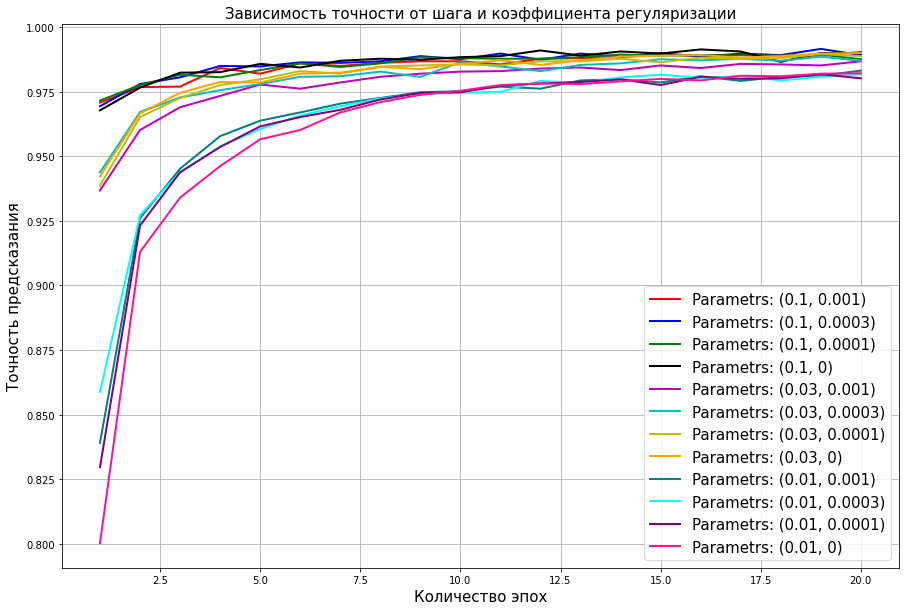

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (15, 10))
plt.title('Зависимость точности от шага и коэффициента регуляризации', fontsize=15)
plt.xlabel('Количество эпох', fontsize=15)
plt.ylabel('Точность предсказания', fontsize=15)
j = 0
for param, accuracy in test_accuracy_history_sgd.items():
    plt.plot(range(1, 21), accuracy, label = "Parametrs: " + str(param), linewidth=2, color=colors[j])
    j += 1
plt.legend(fontsize = 15)
plt.grid(True)
plt.savefig('sgd_1_accrucy.png')

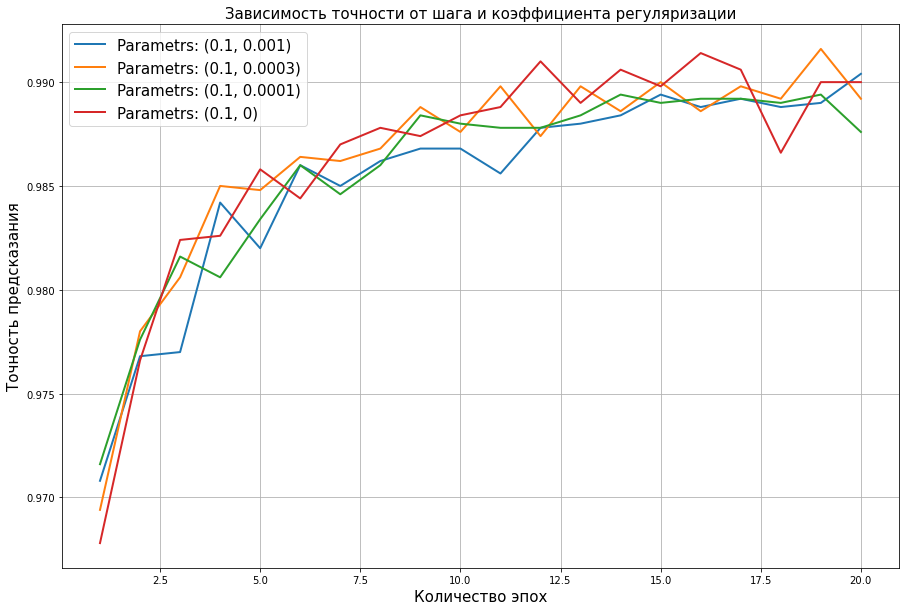

In [ ]:
fig = plt.figure(figsize = (15, 10))
plt.title('Зависимость точности от шага и коэффициента регуляризации', fontsize=15)
plt.xlabel('Количество эпох', fontsize=15)
plt.ylabel('Точность предсказания', fontsize=15)
for  param in product([0.1], [1e-3, 3e-4, 1e-4, 0]):
    plt.plot(range(1, 21), test_accuracy_history_sgd[param], label = "Parametrs: " + str(param), linewidth=2)
plt.legend(fontsize = 15)
plt.grid(True)
plt.savefig('sgd_1_accrucy_small.png')

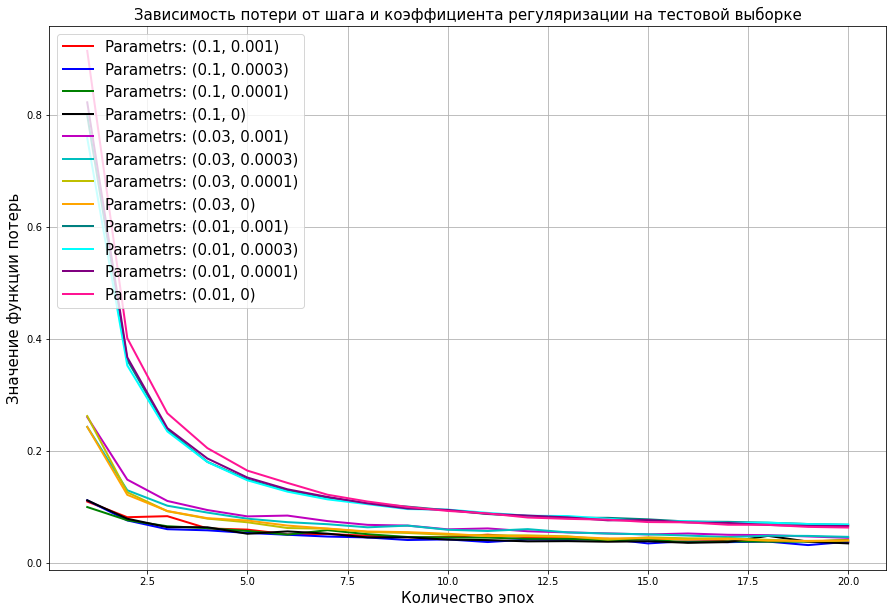

In [ ]:
fig = plt.figure(figsize = (15, 10))
plt.title('Зависимость потери от шага и коэффициента регуляризации на тестовой выборке', fontsize=15)
plt.xlabel('Количество эпох', fontsize=15)
plt.ylabel('Значение функции потерь', fontsize=15)
j = 0
for param, loss in test_loss_history_sgd.items():
    plt.plot(range(1, 21), list(map(lambda x: x.item(), loss)), label = "Parametrs: " + str(param), linewidth=2, color=colors[j])
    j += 1
plt.legend(fontsize = 15, loc='upper left')
plt.grid(True)
plt.savefig('sgd_1_loss.png')

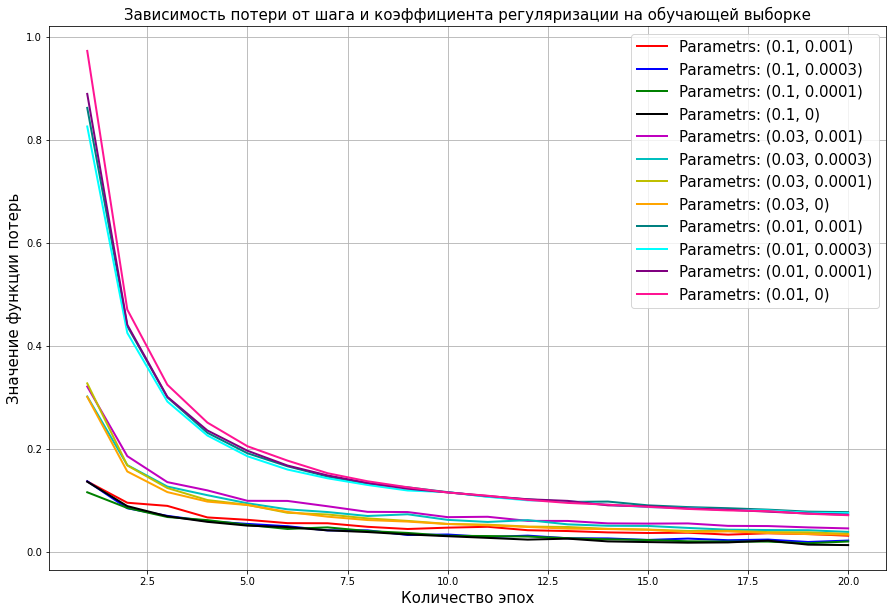

In [ ]:
fig = plt.figure(figsize = (15, 10))
plt.title('Зависимость потери от шага и коэффициента регуляризации на обучающей выборке', fontsize=15)
plt.xlabel('Количество эпох', fontsize=15)
plt.ylabel('Значение функции потерь', fontsize=15)
j = 0
for param, loss in loss_in_training_sgd.items():
    plt.plot(range(1, 21), loss, label = "Parametrs: " + str(param), linewidth=2, color=colors[j])
    j += 1
plt.legend(fontsize = 15)
plt.grid(True)
plt.savefig('sgd_1_loss_train.png')

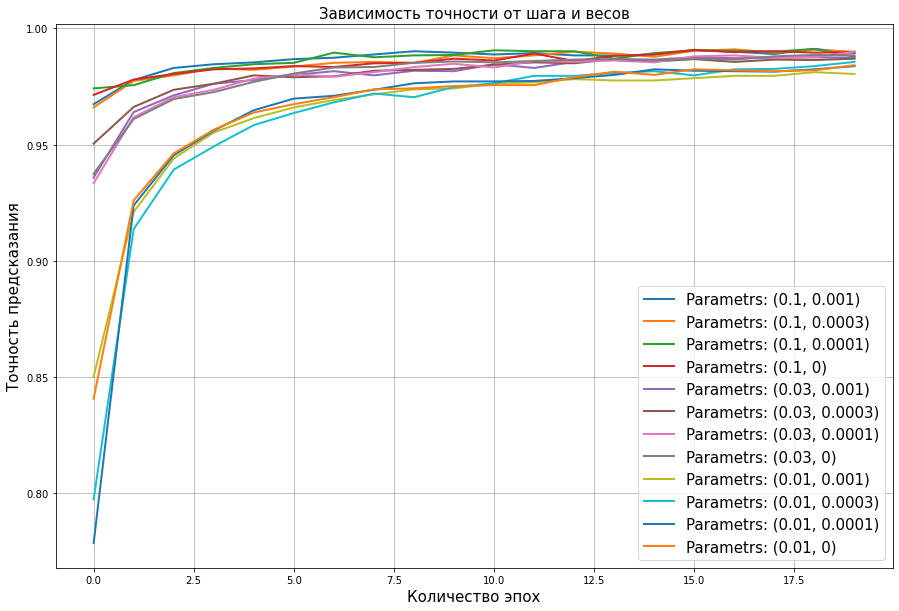

In [ ]:
fig = plt.figure(figsize = (15, 10))
plt.title('Зависимость точности от шага и весов', fontsize=15)
plt.xlabel('Количество эпох', fontsize=15)
plt.ylabel('Точность предсказания', fontsize=15)
for param, accuracy in test_accuracy_history_sgd.items():
    plt.plot(accuracy, label = "Parametrs: " + str(param), linewidth=2)
plt.legend(fontsize = 15)
plt.grid(True)

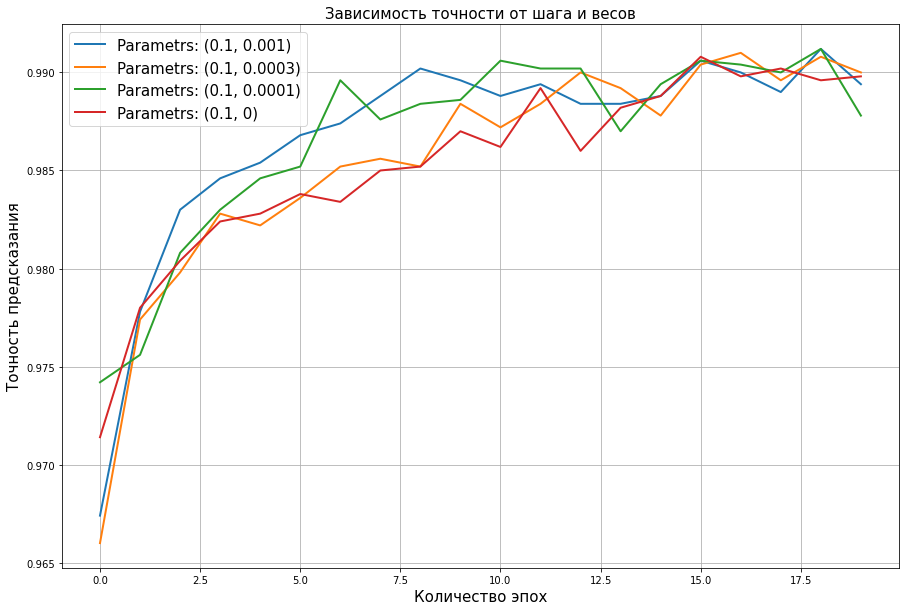

In [ ]:
fig = plt.figure(figsize = (15, 10))
plt.title('Зависимость точности от шага и весов', fontsize=15)
plt.xlabel('Количество эпох', fontsize=15)
plt.ylabel('Точность предсказания', fontsize=15)
for  param in product([0.1], [1e-3, 3e-4, 1e-4, 0]):
    plt.plot(test_accuracy_history_sgd[param], label = "Parametrs: " + str(param), linewidth=2)
plt.legend(fontsize = 15)
plt.grid(True)

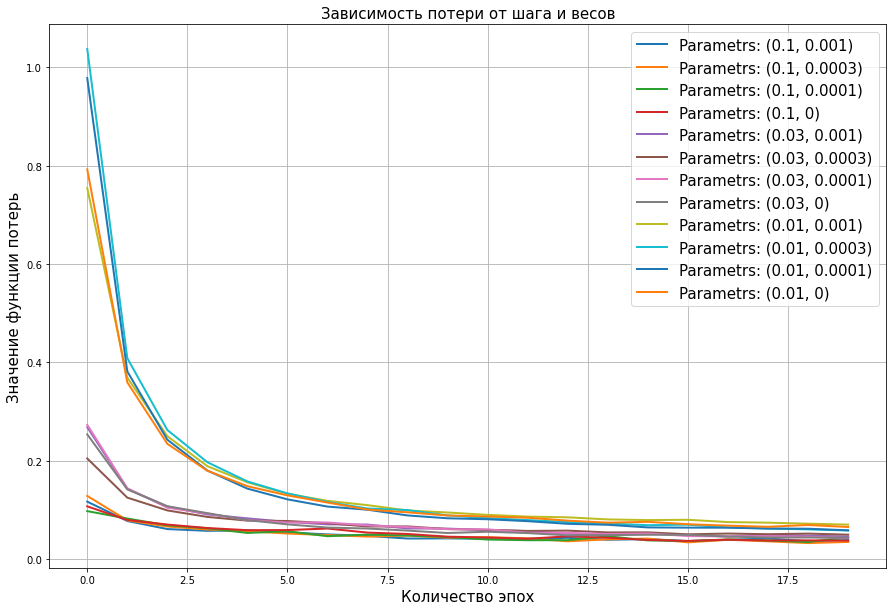

In [ ]:
fig = plt.figure(figsize = (15, 10))
plt.title('Зависимость потери от шага и весов', fontsize=15)
plt.xlabel('Количество эпох', fontsize=15)
plt.ylabel('Значение функции потерь', fontsize=15)
for param, loss in test_loss_history_sgd.items():
    plt.plot(loss, label = "Parametrs: " + str(param), linewidth=2)
plt.legend(fontsize = 15)
plt.grid(True)

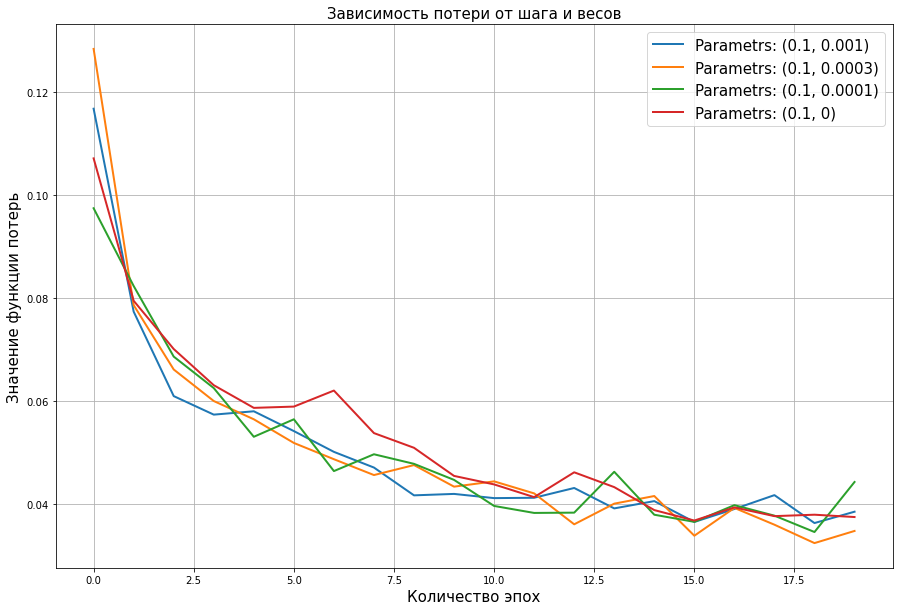

In [ ]:
fig = plt.figure(figsize = (15, 10))
plt.title('Зависимость потери от шага и весов', fontsize=15)
plt.xlabel('Количество эпох', fontsize=15)
plt.ylabel('Значение функции потерь', fontsize=15)
for  param in product([0.1], [1e-3, 3e-4, 1e-4, 0]):
    plt.plot(test_loss_history_sgd[param], label = "Parametrs: " + str(param), linewidth=2)
plt.legend(fontsize = 15)
plt.grid(True)

In [6]:
import tqdm

X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels
X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()

In [7]:
lenet5 = LeNet5()
# lenet5.cuda()
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(lenet5.parameters(), lr=0.1, weight_decay=0)
batch_size = 100

test_loss_history_sgd = list()
test_accuracy_history_sgd = list()
loss_in_training_sgd = list()
time_learning_sgd = list()

for epoch in tqdm.tqdm(range(20)):
    order = np.random.permutation(len(X_train))
    start_time = time.time()
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]
        #X_batch, y_batch = X_batch.cuda(), y_batch.cuda()
        
        preds = lenet5.forward(X_batch) 
        loss_value = loss(preds, y_batch)
        loss_value.backward()   
        optimizer.step()

    time_learning_sgd.append(time.time() - start_time)
    loss_in_training_sgd.append(float(loss(lenet5.forward(X_train), y_train)))

    test_preds = lenet5.forward(X_test)
    test_loss_history_sgd.append(loss(test_preds, y_test).data)
    
    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data
    test_accuracy_history_sgd.append(accuracy)

with open('sgd_mresults.pkl', 'wb') as f:
    pickle.dump({"acc": test_accuracy_history_sgd, "loss": test_loss_history_sgd, "loss_train":loss_in_training_sgd, "time":time_learning_sgd}, f)

100%|██████████| 20/20 [02:00<00:00,  6.01s/it]


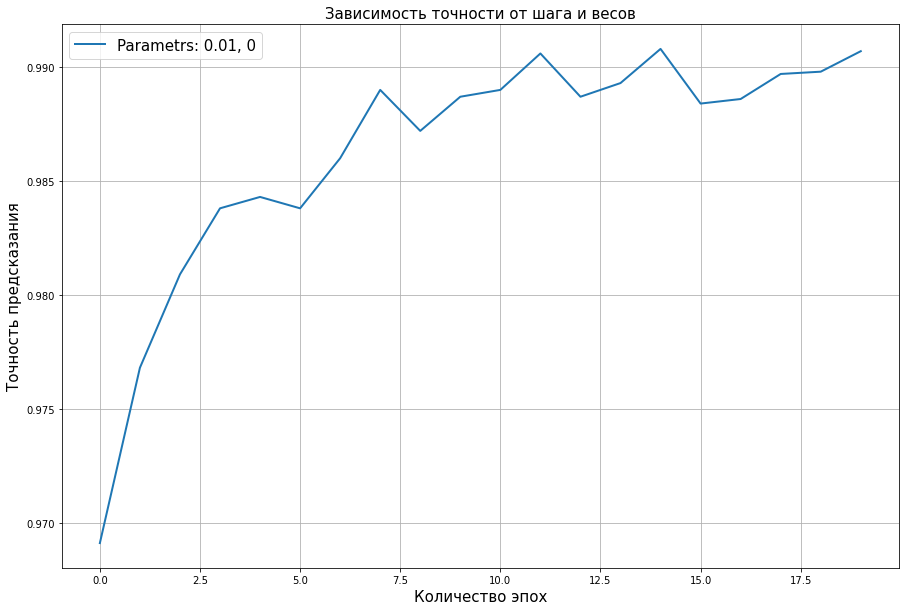

In [15]:
fig = plt.figure(figsize = (15, 10))
plt.title('Зависимость точности от шага и весов', fontsize=15)
plt.xlabel('Количество эпох', fontsize=15)
plt.ylabel('Точность предсказания', fontsize=15)
plt.plot(test_accuracy_history_sgd, label = "Parametrs: 0.1, 0", linewidth=2)
plt.legend(fontsize = 15)
plt.grid(True)

In [11]:
X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels
X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()

In [12]:
lenet5 = LeNet5()
# lenet5.cuda()
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(lenet5.parameters(), lr=0.1, weight_decay=0)
batch_size = 100

test_loss_history_sgd = list()
test_accuracy_history_sgd = list()
loss_in_training_sgd = list()

start_time = time.time()
accuracy = 0

while accuracy <= 0.985:
    
    order = np.random.permutation(len(X_train))
    
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]
        #X_batch, y_batch = X_batch.cuda(), y_batch.cuda()
        
        preds = lenet5.forward(X_batch) 
        loss_value = loss(preds, y_batch)
        loss_value.backward()   
        optimizer.step()

    loss_in_training_sgd.append(float(loss(lenet5.forward(X_train), y_train)))

    test_preds = lenet5.forward(X_test)
    test_loss_history_sgd.append(loss(test_preds, y_test).data)
    
    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data
    test_accuracy_history_sgd.append(accuracy)
    
time_learning_sgd = time.time() - start_time

with open('sgd_mresults_985.pkl', 'wb') as f:
    pickle.dump({"acc": test_accuracy_history_sgd, "loss": test_loss_history_sgd, "loss_train":loss_in_training_sgd, "time":time_learning_sgd}, f)

In [13]:
test_accuracy_history_sgd

[tensor(0.9701),
 tensor(0.9755),
 tensor(0.9810),
 tensor(0.9826),
 tensor(0.9845),
 tensor(0.9852)]

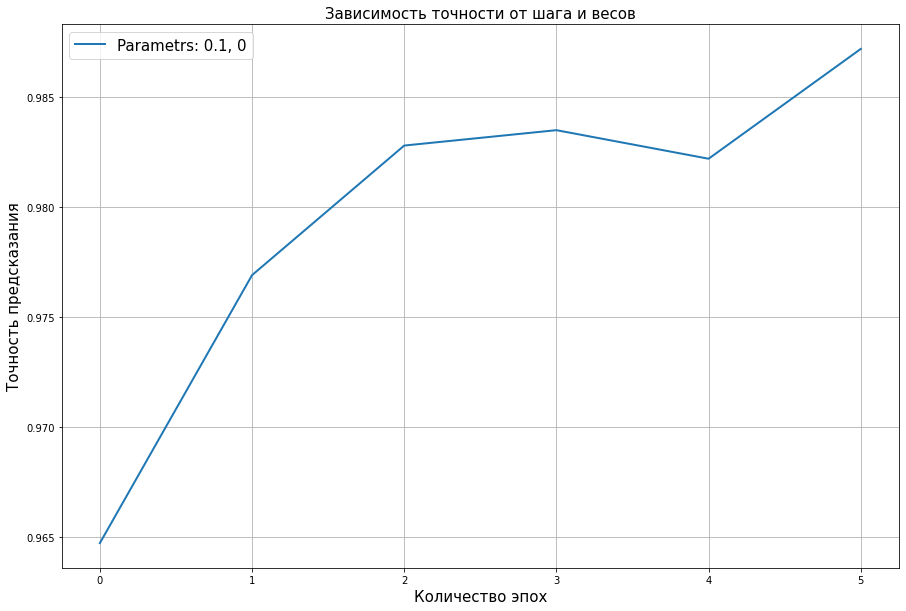

In [26]:
fig = plt.figure(figsize = (15, 10))
plt.title('Зависимость точности от шага и весов', fontsize=15)
plt.xlabel('Количество эпох', fontsize=15)
plt.ylabel('Точность предсказания', fontsize=15)
plt.plot(test_accuracy_history_sgd, label = "Parametrs: 0.1, 0", linewidth=2)
plt.legend(fontsize = 15)
plt.grid(True)